# 0. Imports 

In [1]:
import matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np

# 1. Loading Data 

In [2]:
df1_client_train = pd.read_csv('dataset/client_train.csv', low_memory=False)
df1_invoice_train = pd.read_csv('dataset/invoice_train.csv', low_memory=False)

# 2. Data Description 

In [3]:
df2_client_train = df1_client_train.copy()
df2_invoice_train = df1_invoice_train.copy()

## 2.0 Data Dimensions 

In [4]:
print(f'df2_client_train (lines = {df2_client_train.shape[0]}, cols = {df2_client_train.shape[1]})')
print(f'df2_invoice_train (lines = {df2_invoice_train.shape[0]}, cols = {df2_invoice_train.shape[1]})')

df2_client_train (lines = 135493, cols = 6)
df2_invoice_train (lines = 4476749, cols = 16)


## 2.1 Data Types 

In [5]:
print('-----------------------------------')
print('df2_client_train')
print('-----------------------------------')
print(df2_client_train.dtypes)
print('-----------------------------------')
print('df2_invoice_train')
print('-----------------------------------')
print(df2_invoice_train.dtypes)

-----------------------------------
df2_client_train
-----------------------------------
disrict            int64
client_id         object
client_catg        int64
region             int64
creation_date     object
target           float64
dtype: object
-----------------------------------
df2_invoice_train
-----------------------------------
client_id               object
invoice_date            object
tarif_type               int64
counter_number           int64
counter_statue          object
counter_code             int64
reading_remarque         int64
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
consommation_level_4     int64
old_index                int64
new_index                int64
months_number            int64
counter_type            object
dtype: object


## 2.2 Checking Na 

In [6]:
print('-----------------------------------')
print('df2_client_train')
print('-----------------------------------')
print(df2_client_train.isna().sum())
print('-----------------------------------')
print('df2_invoice_train')
print('-----------------------------------')
print(df2_invoice_train.isna().sum())


-----------------------------------
df2_client_train
-----------------------------------
disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64
-----------------------------------
df2_invoice_train
-----------------------------------
client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64


## 2.3 Data Overview 

### 2.3.1 Clients 

In [7]:
df2_client_train.columns.tolist()

['disrict', 'client_id', 'client_catg', 'region', 'creation_date', 'target']

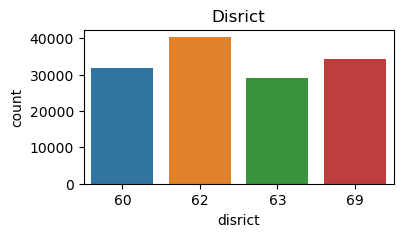

In [8]:
plt.figure(figsize=(4,2));
sns.countplot(data=df2_client_train, x='disrict');
plt.title('Disrict'); # provavelmente distrito

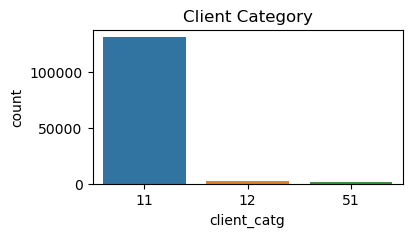

In [9]:
plt.figure(figsize=(4,2));
sns.countplot(data=df2_client_train, x='client_catg');
plt.title('Client Category');

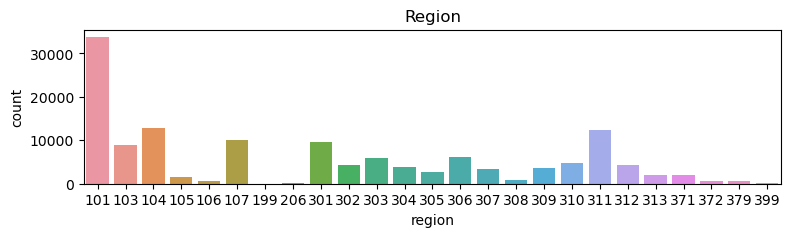

In [10]:
plt.figure(figsize=(9,2));
sns.countplot(data=df2_client_train, x='region');
plt.title('Region');

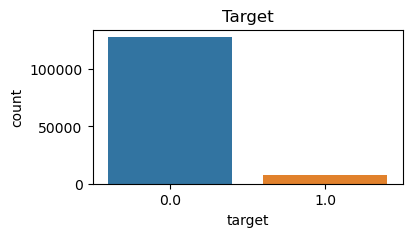

In [11]:
plt.figure(figsize=(4,2))
sns.countplot(data=df2_client_train, x='target');
plt.title('Target');

In [12]:
df2_client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


### 2.3.2 Invoices 

In [13]:
df2_invoice_train.columns.tolist()

['client_id',
 'invoice_date',
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'counter_coefficient',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type']

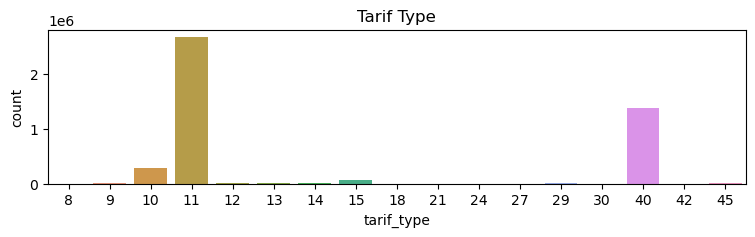

In [14]:
plt.figure(figsize=(9,2))
sns.countplot(data=df2_invoice_train, x='tarif_type');
plt.title('Tarif Type');

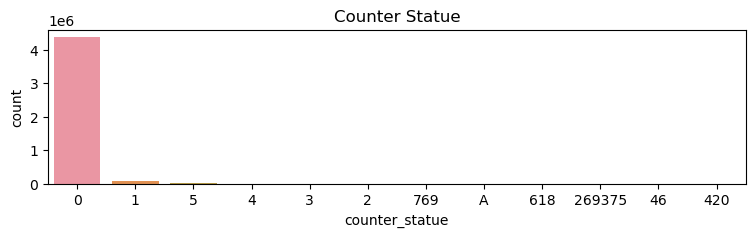

In [15]:
plt.figure(figsize=(9,2))
sns.countplot(data=df2_invoice_train, x='counter_statue');
plt.title('Counter Statue');

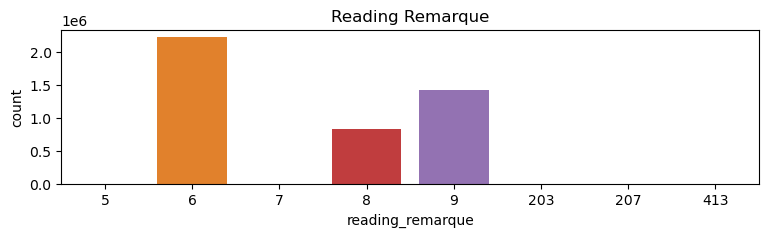

In [16]:
plt.figure(figsize=(9,2));
sns.countplot(data=df2_invoice_train, x='reading_remarque');
plt.title('Reading Remarque');

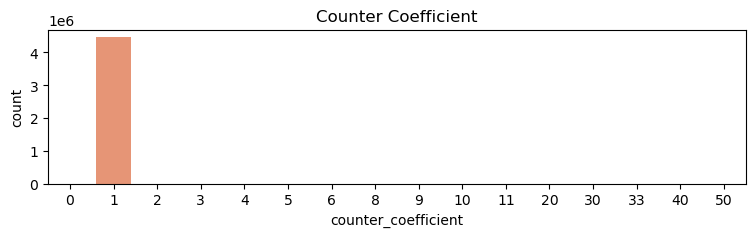

In [17]:
plt.figure(figsize=(9,2));
sns.countplot(data=df2_invoice_train, x='counter_coefficient');
plt.title('Counter Coefficient');

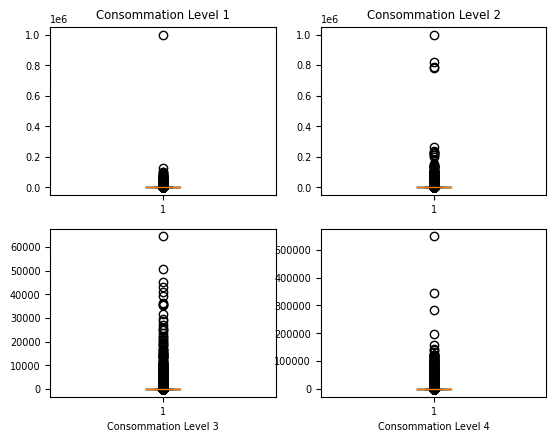

In [18]:
font = {'weight': 'normal', 'size': 7}

matplotlib.rc('font', **font)

plt.subplot(2,2,1);
plt.boxplot(df2_invoice_train.consommation_level_1);
plt.title('Consommation Level 1');

plt.subplot(2,2,2);
plt.boxplot(df2_invoice_train.consommation_level_2);
plt.title('Consommation Level 2');

plt.subplot(2,2,3);
plt.boxplot(df2_invoice_train.consommation_level_3);
plt.xlabel('Consommation Level 3');

plt.subplot(2,2,4);
plt.boxplot(df2_invoice_train.consommation_level_4);
plt.xlabel('Consommation Level 4');

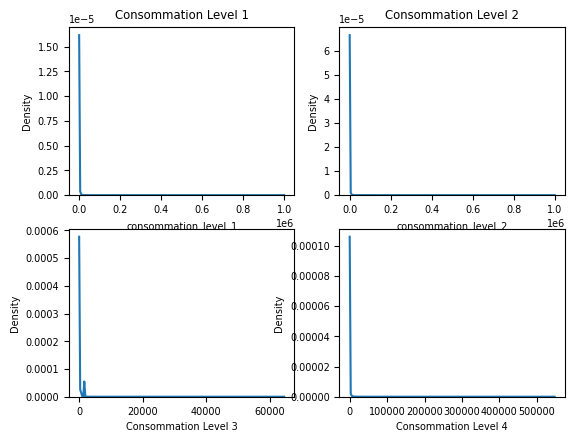

In [19]:
matplotlib.rc('font', **font)

plt.subplot(2,2,1);
sns.kdeplot(x=df2_invoice_train.consommation_level_1);
plt.title('Consommation Level 1');

plt.subplot(2,2,2);
sns.kdeplot(x=df2_invoice_train.consommation_level_2);
plt.title('Consommation Level 2');

plt.subplot(2,2,3);
sns.kdeplot(x=df2_invoice_train.consommation_level_3);
plt.xlabel('Consommation Level 3');

plt.subplot(2,2,4);
sns.kdeplot(x=df2_invoice_train.consommation_level_4);
plt.xlabel('Consommation Level 4');

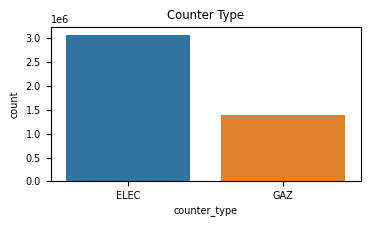

In [20]:
plt.figure(figsize=(4,2));
sns.countplot(data=df2_invoice_train, x='counter_type');
plt.title('Counter Type');

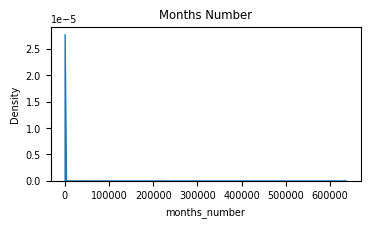

In [21]:
plt.figure(figsize=(4,2));
sns.kdeplot(data=df2_invoice_train, x='months_number', shade=True);
plt.title('Months Number');

In [22]:
df2_invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


## 2.4 Conclusions 

- Alterar o tipo de dado dos atributos 'creation_date' do dataframe de clientes, e os atributos 'reading_remarque',  'invoice_date' e 'counter_type' do dataframe invoices;
- Não existem dados ausentes;
- Como esperado, o target para fraudes é bastante subrepresentado (desbalanceamento);
- 'counter_statue', 'counter_remarquee' e e 'counter_coefficient' precisam ser tratados, pois tem ums distribuição de valores inadequada;
- Existem muito mais invoices de eletricidade que gás no dataset;
- 'consommation_level_x' tem distribuição com bastante outliers, indicando uma variabilidade alta nos consumos;


# 3. Feature Engineering

In [53]:
df3_client_train = df2_client_train.copy()
df3_invoice_train = df2_invoice_train.copy()

## 3.1 Changing Types

### 3.1.1 Client 

In [54]:
df3_client_train.dtypes

disrict            int64
client_id         object
client_catg        int64
region             int64
creation_date     object
target           float64
dtype: object

In [55]:
df3_client_train['creation_date'] = pd.to_datetime(df3_client_train.creation_date, infer_datetime_format=True)
df3_client_train['disrict'] = df3_client_train.disrict.astype('category')
df3_client_train['client_catg'] = df3_client_train.client_catg.astype('category')
df3_client_train['region'] = df3_client_train.region.astype('category')
df3_client_train['target'] = df3_client_train.target.astype('int64')

In [56]:
df3_client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,1994-12-31,0
1,69,train_Client_1,11,107,2002-05-29,0
2,62,train_Client_10,11,301,1986-03-13,0
3,69,train_Client_100,11,105,1996-07-11,0
4,62,train_Client_1000,11,303,2014-10-14,0


### 3.1.2 Invoice 

In [57]:
df3_invoice_train.dtypes

client_id               object
invoice_date            object
tarif_type               int64
counter_number           int64
counter_statue          object
counter_code             int64
reading_remarque         int64
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
consommation_level_4     int64
old_index                int64
new_index                int64
months_number            int64
counter_type            object
dtype: object

In [58]:
df3_invoice_train['invoice_date'] = pd.to_datetime(df3_invoice_train.invoice_date, infer_datetime_format=True)
df3_invoice_train['tarif_type'] = df3_invoice_train.tarif_type.astype('category')
df3_invoice_train['counter_statue'] = df3_invoice_train.counter_statue.astype('category')
df3_invoice_train['reading_remarque'] = df3_invoice_train.reading_remarque.astype('category')
df3_invoice_train['counter_type'] = df3_invoice_train.counter_type.astype('category')

In [59]:
df3_invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


## 3.2 Features Creation and Manipulation

### 3.2.1 Client 

In [60]:
df3_client_train['year_creation'] = df3_client_train.creation_date.dt.year
df3_client_train['month_creation'] = df3_client_train.creation_date.dt.month
df3_client_train['age'] = (2020 - df3_client_train.year_creation) * 12 - df3_client_train.month_creation

In [62]:
df3_client_train.insert(len(df3_client_train.columns)-1, 'target', df3_client_train.pop('target'))
df3_client_train.head()

,disrict,client_id,client_catg,region,creation_date,year_creation,month_creation,age,target
0,60,train_Client_0,11,101,1994-12-31,1994,12,300,0
1,69,train_Client_1,11,107,2002-05-29,2002,5,211,0
2,62,train_Client_10,11,301,1986-03-13,1986,3,405,0
3,69,train_Client_100,11,105,1996-07-11,1996,7,281,0
4,62,train_Client_1000,11,303,2014-10-14,2014,10,62,0


### 3.2.2 Invoice 

In [66]:
df3_invoice_train['delta_index'] = df3_invoice_train.new_index - df3_invoice_train.old_index
df3_invoice_train['counter_type'] = df3_invoice_train.counter_type.map({'ELEC': 1, 'GAZ': 0})
df3_invoice_train['invoice_year'] = df3_invoice_train['invoice_date'].dt.year
df3_invoice_train['invoice_month'] = df3_invoice_train['invoice_date'].dt.month
df3_invoice_train['delta_dates'] = df3_invoice_train.sort_values(['client_id', 'invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)

In [68]:
df3_invoice_train.columns.tolist()

['client_id',
 'invoice_date',
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'counter_coefficient',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'delta_index',
 'invoice_year',
 'invoice_month',
 'delta_dates']

In [73]:
features_to_agg = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'months_number', 'delta_index', 'delta_dates']
stats_features = df3_invoice_train.groupby('client_id')[features_to_agg].agg(['mean','std','min','max'])
stats_features.columns = ['_'.join(col).strip() for col in stats_features.columns.values]

## 3.5 Merging DataFrames

In [78]:
df3 = pd.merge(df3_client_train, stats_features, on='client_id', how='left')
df3.insert(len(df3.columns)-1, 'target', df3.pop('target'))
df3.head()

,disrict,client_id,client_catg,region,creation_date,year_creation,month_creation,age,consommation_level_1_mean,consommation_level_1_std,...,months_number_max,delta_index_mean,delta_index_std,delta_index_min,delta_index_max,delta_dates_mean,delta_dates_std,delta_dates_min,delta_dates_max,target
0,60,train_Client_0,11,101,1994-12-31,1994,12,300,352.400000,310.343472,...,12,362.971429,341.553930,38,1386,144.147059,87.601070,40.0,508.0,0
1,69,train_Client_1,11,107,2002-05-29,2002,5,211,557.540541,197.935960,...,8,557.540541,197.935960,190,1207,136.472222,92.492312,4.0,372.0,0
2,62,train_Client_10,11,301,1986-03-13,1986,3,405,798.611111,513.841374,...,12,836.500000,646.808386,188,3082,289.470588,250.701794,20.0,738.0,0
3,69,train_Client_100,11,105,1996-07-11,1996,7,281,1.200000,3.607011,...,6,1.200000,3.607011,0,15,140.210526,95.569974,4.0,442.0,0
4,62,train_Client_1000,11,303,2014-10-14,2014,10,62,663.714286,224.831365,...,4,922.642857,633.485669,124,2382,121.923077,80.057752,4.0,301.0,0


# 4. Exploratory Data Analysis 

# 5. Data Preparation 

# 6. Features Selection 

# 7. Machine Learning Model 

# 8. Fine Tuning 

# 9. Cross Validation 